<a href="https://colab.research.google.com/github/rajbircit/assignments/blob/main/dl_a2/pretrained.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

#### Show the environment

In [1]:
!nvidia-smi
print()
print()
print('=' * 80)
print()
print()
!df -h
print()
print()
print('=' * 80)
print()
print()
!free -m
print()
print()
print('=' * 80)
print()
print()
!lscpu
print()
print()
print('=' * 80)
print()
print()
! ps -eo pmem,pcpu,vsize,pid,cmd | sort -k 1 -nr | head -5


Sun Apr 25 13:35:54 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Some Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn import metrics, model_selection
from statistics import mean, median
from time import perf_counter
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_predict
from sklearn.metrics import make_scorer
from sklearn.ensemble import IsolationForest
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier, Perceptron, RidgeClassifier, SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestClassifier
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn import model_selection
from sklearn import linear_model
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SelectFromModel
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFwe, chi2, f_classif
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


#### Setup logging

In [3]:
import tensorflow as tf
from keras.utils import np_utils
import numpy as np
import logging
import sys
import random
import matplotlib.pyplot as plt
import os
from google.colab import drive
import shutil
import zipfile
import h5py
import gc
import IPython

np.random.seed(1)
random.seed(1)
tf.random.set_seed(1)

root = logging.getLogger()
root.setLevel(logging.INFO)

handler = logging.StreamHandler(sys.stdout)
handler.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)
root.addHandler(handler)

random.seed(5)
tf.random.set_seed(5)
np.random.seed(5)

#### Mount Google Drive And Copy Files

In [4]:
drive.mount('/content/gdrive')

if (os.path.exists("/root/imagedata")):
    ret = shutil.rmtree("/root/imagedata")
os.mkdir("/root/imagedata")
shutil.copyfile( \
    "/content/gdrive/MyDrive/DeepLearningAssignment2/earth_data.zip",
    "/root/imagedata/earth_data.zip")

!cd /root/imagedata && unzip earth_data.zip && rm -f earth_data.zip

Mounted at /content/gdrive
Archive:  earth_data.zip
  inflating: earth_data.h5           


## Code to plot graphs and remember histories

In [5]:
class Entry:
    def __init__(self, loss, val_loss, accuracy, val_accuracy, best_accuracy, best_loss):
        self.loss = loss
        self.val_loss = val_loss
        self.accuracy = accuracy
        self.val_accuracy = val_accuracy
        self.best_accuracy = best_accuracy
        self.best_loss = best_loss

class Plot:
    def __init__(self):
        self.history = {}
        self.colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'tab:blue', \
                       'tab:orange', 'tab:green', 'tab:red', 'tab:purple', \
                       'tab:brown', 'tab:pink', 'tab:olive', 'tab:cyan']

    def plot_history(self, history, N_EPOCHS, name, show=True):
        if show:
            N_EPOCHS = len(history.history["loss"])
            plt.rcParams["figure.figsize"] = (20, 10)
            plt.xticks(np.arange(0, N_EPOCHS+1, 1.0))
            plt.plot(np.arange(0, N_EPOCHS), history.history["loss"], label="train loss", color='blue', linestyle='solid')
            plt.plot(np.arange(0, N_EPOCHS), history.history["val_loss"], label="val loss", color='blue', linestyle='dashdot')
            plt.plot(np.arange(0, N_EPOCHS), history.history["accuracy"], label="train acc", color='red', linestyle='solid')
            plt.plot(np.arange(0, N_EPOCHS), history.history["val_accuracy"], label="val acc", color='red', linestyle='dashdot')
            plt.legend()
            plt.show()
        best_val_acc = max(history.history['val_accuracy'])
        index_best_val_accuracy = history.history['val_accuracy'].index(best_val_acc)
        best_val_loss = min(history.history['val_loss'])
        index_best_val_loss = history.history['val_loss'].index(best_val_loss)
        if show:
            print(f"Best validation accuracy: {best_val_acc}, epoch = {index_best_val_accuracy}")
            print(f"Best validation loss: {best_val_loss}, epoch = {index_best_val_loss}")
        entry = Entry(\
                      loss=history.history["loss"],\
                      val_loss=history.history["val_loss"],\
                      accuracy=history.history["accuracy"],\
                      val_accuracy=history.history["val_accuracy"],\
                      best_accuracy=best_val_acc,
                      best_loss=best_val_loss)
        self.history[name] = entry
        gc.collect()

    def superplot(self):
        i = 0
        plt.rcParams["figure.figsize"] = [30, 10]
        fig, ax = plt.subplots(1, 2)
        def innerplot(self, ax, arr, text, linest):
            ax.plot(np.arange(0, len(arr)), arr, label=text, color=self.colors[i], linestyle=linest)
        for name, entry in self.history.items():
            innerplot(self, ax[0], entry.loss, f"{name}-loss", "solid")
            innerplot(self, ax[0], entry.val_loss, f"{name}-val-loss", "dashdot")
            innerplot(self, ax[1], entry.accuracy, f"{name}-accuracy", "solid")
            innerplot(self, ax[1], entry.val_accuracy, f"{name}-val-accuracy", "dashdot")
            i += 1
        ax[0].legend()
        ax[1].legend()
        plt.show()



## Extract train and test instances

In [6]:
def loadDataH5():
    with h5py.File('/root/imagedata/earth_data.h5','r') as hf:
        trainX = np.array(hf.get('trainX'))
        trainY = np.array(hf.get('trainY'))
        valX = np.array(hf.get('valX'))
        valY = np.array(hf.get('valY'))
        print (trainX.shape,trainY.shape)
        print (valX.shape,valY.shape)
        return trainX, trainY, valX, valY

trainX, trainY, valX, valY = loadDataH5()
trainX = trainX / 255.0
valX = valX / 255.0

(19200, 64, 64, 3) (19200,)
(4800, 64, 64, 3) (4800,)


## Callbacks

In [7]:
def decay_after_runs(N):
    NRUNS = N
    # We're sneaking this in, since this will be called at every epoch
    # it also gives us a good way to force calls to gc() within the fit function
    gc.collect()
    def learning_rate_scheduler(epoch, lr):
        if NRUNS < 0 or epoch < NRUNS:
            return lr
        else:
            print(f"Learning Rate: {lr} --> {lr * tf.math.exp(-1.0)}")
            return lr * tf.math.exp(-0.1)
    return learning_rate_scheduler
lr_callback = tf.keras.callbacks.LearningRateScheduler(decay_after_runs(20))

early_stopping = tf.keras.callbacks.EarlyStopping(\
                                                  monitor='val_loss',\
                                                  patience=3,
                                                  verbose=1,
                                                  mode='auto')
early_stopping2 = tf.keras.callbacks.EarlyStopping(\
                                                  monitor='val_loss',\
                                                  patience=10,
                                                  verbose=1,
                                                  mode='auto')


reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(\
                                                 monitor='val_loss',\
                                                 factor=0.5,\
                                                 patience=3,\
                                                 min_lr=0.001)

term_on_nan = tf.keras.callbacks.TerminateOnNaN()

DRIVE_FOLDER = "/content/gdrive/MyDrive/DeepLearningAssignment2"

def get_checkpoint_callback(name):
    checkpoint_filepath = f"{DRIVE_FOLDER}/ckp-{name}"
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True)
    return model_checkpoint_callback


def get_callbacks_decay_after(N, name=None):
    if N == -2:
        callback_array = [\
                        tf.keras.callbacks.LearningRateScheduler(\
                                                    decay_after_runs(-1)),
                        early_stopping2,
                        term_on_nan,
                        ]
    else:
        callback_array = [\
                        tf.keras.callbacks.LearningRateScheduler(\
                                                    decay_after_runs(N)),
                        early_stopping,
                        term_on_nan,
                        ]
    if N > 0:
        callback_array.append(reduce_lr)
    if None != name:
        callback_array.append(get_checkpoint_callback(name))
    return callback_array

## 1. Load the VGG Model


In [8]:
vgg = tf.keras.applications.VGG16(\
                                  include_top=False,\
                                  weights='imagenet',\
                                  input_shape=trainX[0].shape)

58892288/58889256 [==============================] - 1s 0us/step


In [9]:
print(vgg.summary())

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0     

In [10]:
featuresTrain = vgg.predict(trainX)
featuresVal = vgg.predict(valX)

Training model DecisionTreeClassifier
Accuracy = 0.6385416666666667
Training model NaiveBayes
Accuracy = 0.5022916666666667
Training model Random Forest
Accuracy = 0.8166666666666667


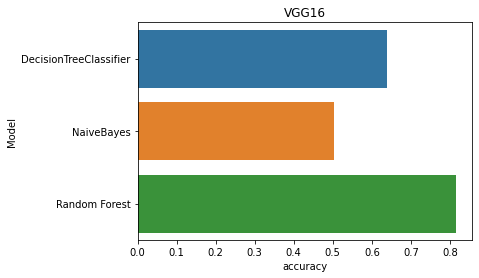

In [11]:
import pandas as pd
import seaborn as sns
gc.collect()

def feature_extraction_test(\
                            model_name:str,\
                            model,\
                            trainX,\
                            trainY,\
                            valX,\
                            valY
                            ):
    def secondary_classification(\
                                 model,\
                                 trainX,\
                                 trainY,\
                                 valX,\
                                 valY):
        model.fit(trainX, trainY)
        y_pred = model.predict(valX)
        return accuracy_score(valY, y_pred)

    basic_models = [
        ('DecisionTreeClassifier', lambda: DecisionTreeClassifier(random_state=1)),
        ('NaiveBayes', lambda: GaussianNB()),
        ('Random Forest', lambda: RandomForestClassifier(random_state=1)),
    ]

    m_names = []
    m_acc = []
    t_trainX = model.predict(trainX)
    t_valX = model.predict(valX)
    t_trainX = t_trainX.reshape(t_trainX.shape[0], -1)
    t_valX = t_valX.reshape(t_valX.shape[0], -1)
    scaler = StandardScaler().fit(t_trainX)
    t_trainX = scaler.transform(t_trainX)
    t_valX = scaler.transform(t_valX)

    for (n, m) in basic_models:
        print(f"Training model {n}")
        accuracy = secondary_classification(m(),\
                                            t_trainX,\
                                            trainY,\
                                            t_valX,\
                                            valY)
        print(f"Accuracy = {accuracy}")
        m_names.append(n)
        m_acc.append(accuracy)
        
    df = pd.DataFrame({"Model": pd.Series(m_names), "accuracy": pd.Series(m_acc)})
    p = sns.barplot(y='Model', x='accuracy', data=df, orient='h')
    p.set_title(model_name)
    plt.show()
    return m_names, m_acc

    

vgg16 = tf.keras.applications.VGG16(\
                                  include_top=False,\
                                  weights='imagenet',\
                                  input_shape=trainX[0].shape)
vg16_names, vgg16_acc = feature_extraction_test("VGG16", vgg16, trainX, trainY, valX, valY)





Training model DecisionTreeClassifier
Accuracy = 0.604375
Training model NaiveBayes
Accuracy = 0.47041666666666665
Training model Random Forest
Accuracy = 0.7758333333333334


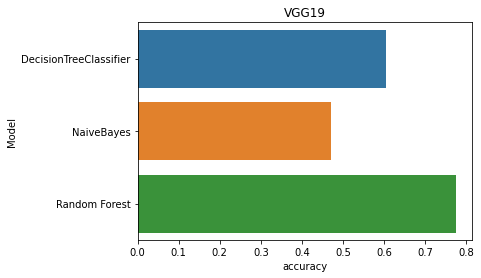

In [13]:
vgg19 = tf.keras.applications.VGG19(\
                                    include_top=False,\
                                    weights='imagenet',\
                                    input_shape=trainX[0].shape)
vgg19_names, vgg19_acc = feature_extraction_test("VGG19",\
                                                 vgg19,\
                                                 trainX,\
                                                 trainY,\
                                                 valX,\
                                                 valY)

Training model DecisionTreeClassifier
Accuracy = 0.568125
Training model NaiveBayes
Accuracy = 0.5095833333333334
Training model Random Forest
Accuracy = 0.7585416666666667


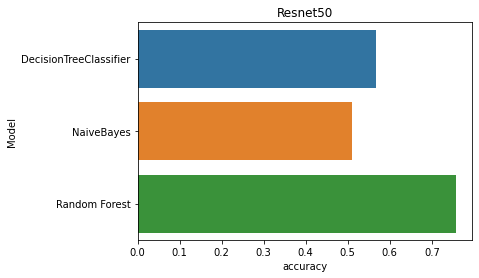

In [19]:
gc.collect()
resnet50 = tf.keras.applications.ResNet50V2(\
                                          include_top=False,\
                                          weights='imagenet',\
                                          input_shape=trainX[0].shape)
                               
resnet50_names, resnet50_acc = feature_extraction_test(\
                                                       "Resnet50",\
                                                       resnet50,\
                                                       trainX,\
                                                       trainY,\
                                                       valX,\
                                                       valY)

74842112/74836368 [==============================] - 2s 0us/step
Training model DecisionTreeClassifier
Accuracy = 0.626875
Training model NaiveBayes
Accuracy = 0.71
Training model Random Forest
Accuracy = 0.8375


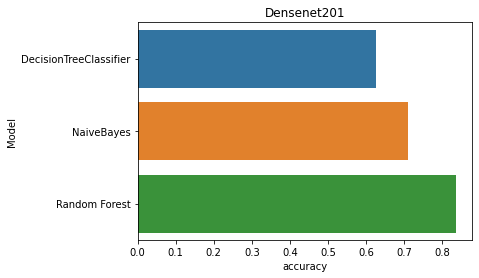

In [22]:
densenet = tf.keras.applications.DenseNet201(\
                                  include_top=False,\
                                  input_shape=trainX[0].shape)
densenet_names, densenet_acc = feature_extraction_test(\
                                                       "Densenet201",\
                                                       densenet,\
                                                       trainX,\
                                                       trainY,\
                                                       valX,\
                                                       valY)

   Pretrained Model                             variable     value
0             VGG16  Trainable Params (tens of millions)  1.471469
1             VGG19  Trainable Params (tens of millions)  2.002438
2          ResNet50  Trainable Params (tens of millions)  2.356480
3          DenseNet  Trainable Params (tens of millions)  1.832198
4             VGG16               DecisionTreeClassifier  0.638542
5             VGG19               DecisionTreeClassifier  0.604375
6          ResNet50               DecisionTreeClassifier  0.568125
7          DenseNet               DecisionTreeClassifier  0.626875
8             VGG16                           NaiveBayes  0.502292
9             VGG19                           NaiveBayes  0.470417
10         ResNet50                           NaiveBayes  0.509583
11         DenseNet                           NaiveBayes  0.710000
12            VGG16                        Random Forest  0.816667
13            VGG19                        Random Forest  0.77

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3720: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.0, 'Comparison of various pre-trained models')

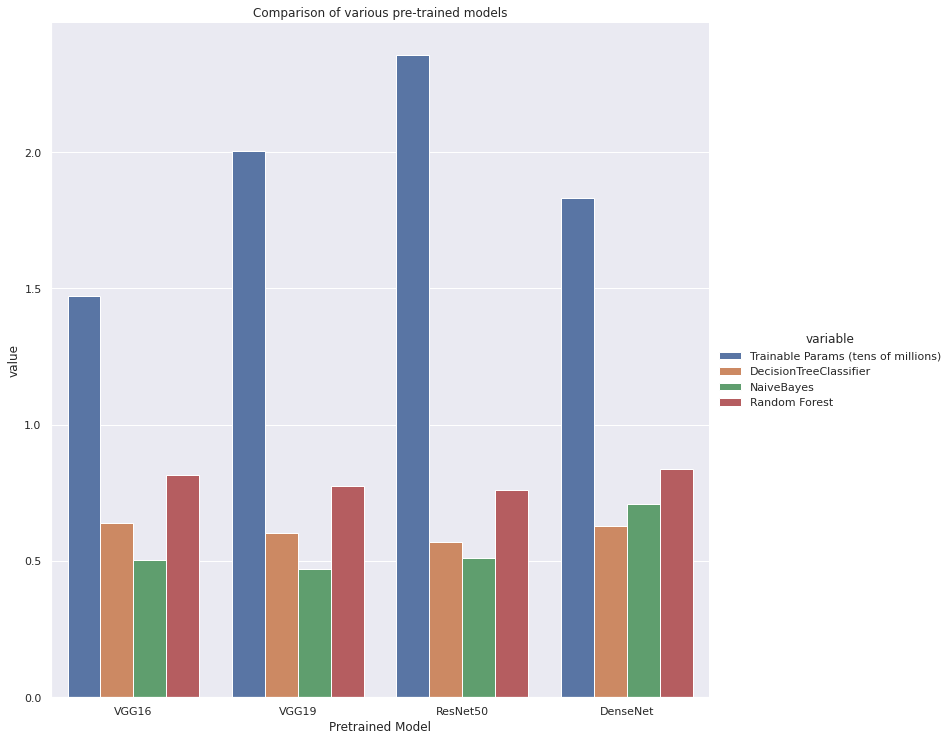

In [41]:
classifier_names = densenet_names
models = [vgg16, vgg19, resnet50, densenet]
accuracies = [vgg16_acc, vgg19_acc, resnet50_acc, densenet_acc]
pretrained=['VGG16', 'VGG19', 'ResNet50', 'DenseNet']
parameters = [m.count_params() / (10_000_000) for m in models]
data = {}
data["Pretrained Model"] = pretrained
data["Trainable Params (tens of millions)"] = parameters
for i, name in enumerate(classifier_names):
    arr = []
    for acc_arr in accuracies:
        arr.append(acc_arr[i])
    data[name] = arr
dfs = pd.DataFrame(data)
dfs1 = pd.melt(dfs, id_vars="Pretrained Model")
print(dfs1)
sns.set(rc={'figure.figsize':(20, 15,)})
p = sns.factorplot(x="Pretrained Model", y='value', hue='variable', data=dfs1, kind='bar', size=10)
plt.title('Comparison of various pre-trained models')